# Лаборатоная работа №6

# Случайный лес (Random Forest)

<div style = "font-size: 16px">
    <p><b>Цель работы: </b></p>
    <ol>
    <li>Освоить метод Random Forest (Случайный лес) - алгоритм машинного обучения, относящийся к классу ансамблевых методов.</li>
    <li>Создать и обучить модель Random Forest.</li>
    <li>Оценить эффективность алгоритма на практическом примере.</li>
    <li>Подобрать гиперпараметры дял улучшения модели.</li>
    </ol>
    <p>В этой работе мы используем набор данных о маркетинговых кампаниях банка (bank.csv) для задачи бинарной классификации: предсказать, подпишется ли клиент на срочный депозит (переменная y: "yes"/"no").</p>
</div>

### 1. Импортируйте необходимые библиотеки

In [1]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

# Для воспроизводимости результатов
np.random.seed(42)

### 2. Загрузка и первичный анализ данных

In [2]:
# Загружаем набор данных о маркетинговых кампаниях банка (бинарная классификация)
df = pd.read_csv('bank.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [4]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [5]:
df.shape

(4521, 17)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


### 3. Исключаем невлияющие категориальные признаки

In [7]:
df_copy = df.copy()
drop_feat = ['contact', 'day', 'month', 'pdays']
df_copy.drop(drop_feat, axis=1, inplace=True)
df_copy.head()

,age,job,marital,education,default,balance,housing,loan,duration,campaign,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,79,1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,220,1,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,185,1,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,199,4,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,226,1,0,unknown,no


<p style = "font-size: 16px">Признаки deafult, housing, loan и y имеют два значения - no и yes. Эти признаки, по сути, бинарные и можно использовать значения 0 и 1.</p>

In [8]:
binary_map = {'no': 0, 'yes': 1}
binary_features = ['default', 'housing', 'loan', 'y']
for feature in binary_features:
    df_copy[feature] = df_copy[feature].map(binary_map)
df_copy.head()

,age,job,marital,education,default,balance,housing,loan,duration,campaign,previous,poutcome,y
0,30,unemployed,married,primary,0,1787,0,0,79,1,0,unknown,0
1,33,services,married,secondary,0,4789,1,1,220,1,4,failure,0
2,35,management,single,tertiary,0,1350,1,0,185,1,1,failure,0
3,30,management,married,tertiary,0,1476,1,1,199,4,0,unknown,0
4,59,blue-collar,married,secondary,0,0,1,0,226,1,0,unknown,0


In [9]:
df_copy['job_indicator'] = np.where(df_copy['job'] == 'unemployed', 0, 1)
df_copy.drop('job', axis=1, inplace=True)
df_copy.head()

,age,marital,education,default,balance,housing,loan,duration,campaign,previous,poutcome,y,job_indicator
0,30,married,primary,0,1787,0,0,79,1,0,unknown,0,0
1,33,married,secondary,0,4789,1,1,220,1,4,failure,0,1
2,35,single,tertiary,0,1350,1,0,185,1,1,failure,0,1
3,30,married,tertiary,0,1476,1,1,199,4,0,unknown,0,1
4,59,married,secondary,0,0,1,0,226,1,0,unknown,0,1


In [10]:
marital_map = {'single': 0, 'married': 1, 'divorced': 2}
df_copy['marital'] = df_copy['marital'].map(marital_map)

education_map = {'unknown': 0, 'primary': 1, 'secondary': 2, 'tertiary': 3}
df_copy['education'] = df_copy['education'].map(education_map)

poutcome_map = {'unknown': 0, 'failure': 1, 'other': 2, 'success': 3}
df_copy['poutcome'] = df_copy['poutcome'].map(poutcome_map)

df_copy.head()

,age,marital,education,default,balance,housing,loan,duration,campaign,previous,poutcome,y,job_indicator
0,30,1,1,0,1787,0,0,79,1,0,0,0,0
1,33,1,2,0,4789,1,1,220,1,4,1,0,1
2,35,0,3,0,1350,1,0,185,1,1,1,0,1
3,30,1,3,0,1476,1,1,199,4,0,0,0,1
4,59,1,2,0,0,1,0,226,1,0,0,0,1


In [11]:
#Повторная проверка
df_copy.isnull().sum()

age              0
marital          0
education        0
default          0
balance          0
housing          0
loan             0
duration         0
campaign         0
previous         0
poutcome         0
y                0
job_indicator    0
dtype: int64

In [12]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   age            4521 non-null   int64
 1   marital        4521 non-null   int64
 2   education      4521 non-null   int64
 3   default        4521 non-null   int64
 4   balance        4521 non-null   int64
 5   housing        4521 non-null   int64
 6   loan           4521 non-null   int64
 7   duration       4521 non-null   int64
 8   campaign       4521 non-null   int64
 9   previous       4521 non-null   int64
 10  poutcome       4521 non-null   int64
 11  y              4521 non-null   int64
 12  job_indicator  4521 non-null   int64
dtypes: int64(13)
memory usage: 459.3 KB


### 4. Разделяем данные на признаки и целевую переменную

In [14]:
# Разделяем данные на обучающую и тестовую выборки (70/30)
y = df_copy['y']
X = df_copy.drop('y', axis = 1)
X

,age,marital,education,default,balance,housing,loan,duration,campaign,previous,poutcome,job_indicator
0,30,1,1,0,1787,0,0,79,1,0,0,0
1,33,1,2,0,4789,1,1,220,1,4,1,1
2,35,0,3,0,1350,1,0,185,1,1,1,1
3,30,1,3,0,1476,1,1,199,4,0,0,1
4,59,1,2,0,0,1,0,226,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,1,2,0,-333,1,0,329,5,0,0,1
4517,57,1,3,1,-3313,1,1,153,1,0,0,1
4518,57,1,2,0,295,0,0,151,11,0,0,1
4519,28,1,2,0,1137,0,0,129,4,3,2,1


### 5. Применяем операцию нормализации для численной устойчивости

In [15]:
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
X = standardizer.fit_transform(X)
X

array([[-1.05626965,  0.24642938, -1.36512338, ..., -0.32041282,
        -0.41430603, -5.85835408],
       [-0.77258281,  0.24642938, -0.08441726, ...,  2.04173372,
         1.05939778,  0.17069641],
       [-0.58345826, -1.42139579,  1.19628886, ...,  0.27012381,
         1.05939778,  0.17069641],
       ...,
       [ 1.49691189,  0.24642938, -0.08441726, ..., -0.32041282,
        -0.41430603,  0.17069641],
       [-1.24539421,  0.24642938, -0.08441726, ...,  1.45119709,
         2.53310159,  0.17069641],
       [ 0.26760226, -1.42139579,  1.19628886, ...,  3.81334363,
         2.53310159,  0.17069641]], shape=(4521, 12))

In [16]:
# Сохраняем имена признаков и делаем DataFrame обратно, чтобы потом оценить важность признаков
feature_names = df_copy.drop('y', axis=1).columns
X = pd.DataFrame(X, columns=feature_names)

### 6. Разделение данных на обучающую и тестовую выборки

In [17]:
# Разделяем данные на обучающую и тестовую выборки (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Обучающая выборка: {X_train.shape[0]} samples")
print(f"Тестовая выборка: {X_test.shape[0]} samples")

Обучающая выборка: 3164 samples
Тестовая выборка: 1357 samples


### 7. Создание и обучение модели Random Forest

In [18]:
# Создаем модель Random Forest
# n_estimators - количество деревьев в лесу
# random_state - для воспроизводимости результатов
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Обучаем модель на обучающих данных
rf_model.fit(X_train, y_train)

print("Модель Random Forest обучена!")

Модель Random Forest обучена!


### 8. Прогнозирование и оценка модели

In [19]:
# Делаем прогнозы на тестовой выборке
y_pred = rf_model.predict(X_test)

# Оцениваем точность модели
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели на тестовой выборке: {accuracy:.4f}")

Точность модели на тестовой выборке: 0.8887


In [20]:
# Выводим подробный отчет по классификации
target_names = ['Not y', 'y']
print("\n" + "="*50)
print("Отчет по классификации:")
print("="*50)
print(classification_report(y_test, y_pred, target_names=target_names))


Отчет по классификации:
              precision    recall  f1-score   support

       Not y       0.91      0.97      0.94      1205
           y       0.51      0.24      0.33       152

    accuracy                           0.89      1357
   macro avg       0.71      0.61      0.63      1357
weighted avg       0.87      0.89      0.87      1357



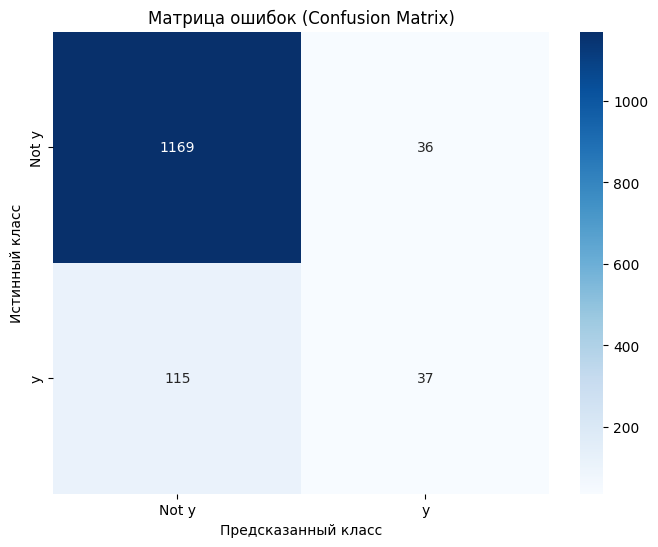

In [21]:
# Строим матрицу ошибок
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Матрица ошибок (Confusion Matrix)")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.show()

### 9. Анализ важности признаков

<p style = "font-size: 16px">Одна из ключевых особенностей Random Forest - возможность оценить важность каждого признака.</p>

In [22]:
# Важность признаков на основе среднего уменьшения неоднородности (Gini Importance)
feature_importances = rf_model.feature_importances_
features_df = pd.DataFrame({"feature": X.columns, "importance": feature_importances})
features_df = features_df.sort_values("importance", ascending=False)

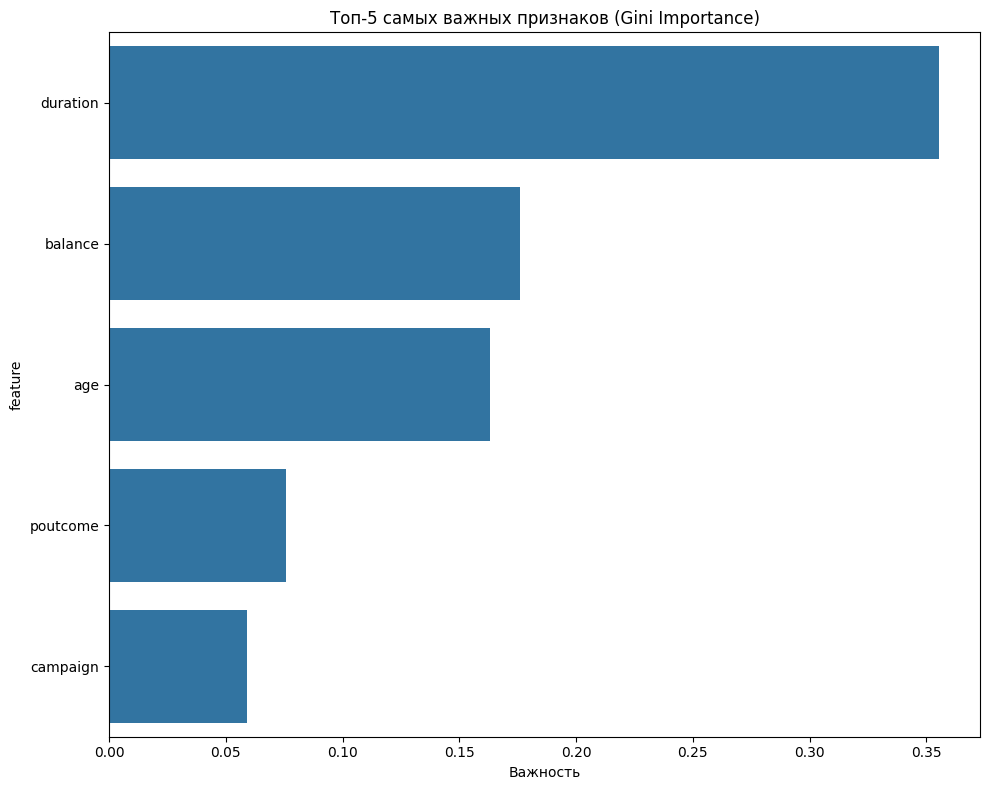

In [24]:
# Визуализация важности признаков
plt.figure(figsize=(10, 8))
sns.barplot(x="importance", y="feature", data=features_df.head(5)) # Покажем топ-5 признаков
plt.title("Топ-5 самых важных признаков (Gini Importance)")
plt.xlabel("Важность")
plt.tight_layout()
plt.show()

In [25]:
# Вывод таблицы с важностью признаков
print("Топ-5 самых важных признаков:")
print(features_df.head(5))

Топ-5 самых важных признаков:
     feature  importance
7   duration    0.355208
4    balance    0.176138
0        age    0.163152
10  poutcome    0.075711
8   campaign    0.059134


### 10. Подбор гиперпараметров

<p style = "font-size: 16px">Для улучшения модели можно подобрать оптимальные гиперпараметры с помощью GridSearchCV</p>

In [26]:
from sklearn.model_selection import GridSearchCV

# Определяем сетку параметров для перебора
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

In [27]:
# Создаем модель для поиска
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring="accuracy", n_jobs=-1)

# Запускаем поиск (может занять некоторое время)
grid_search.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [None, 10, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [50, 100, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold a

In [28]:
# Выводим лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность при кросс-валидации: {:.4f}".format(grid_search.best_score_))

Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Лучшая точность при кросс-валидации: 0.8998


In [29]:
# Оцениваем лучшую модель на тестовых данных
best_rf_model = grid_search.best_estimator_
y_pred_best = best_rf_model.predict(X_test)
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Точность улучшенной модели на тестовой выборке: {best_accuracy:.4f}")

Точность улучшенной модели на тестовой выборке: 0.8917
